In [2]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

%matplotlib inline

In [3]:
def get_data(coin = 'bitcoin', year = 2017):
    
    df = pd.read_csv(f'./data/{coin}_{year}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')
    df.set_index('timestamp', inplace = True)
    df.sort_index(inplace = True)
    df = df[['Count','Open','High','Low','Close','Volume','VWAP','Target']]
    
    return df

In [4]:
btc2017 = get_data()
btc2018 = get_data('bitcoin', 2018)
btc2019 = get_data('bitcoin', 2019)
btc2020 = get_data('bitcoin', 2020)
btc2021 = get_data('bitcoin', 2021)

In [5]:
btc = pd.concat([btc2017, btc2018, btc2019, btc2020, btc2021], axis = 0)

In [6]:
def resample(df, time_period = '1D'):
    df = df.resample(time_period).first()
    return df

In [7]:
def add_cols(df, momentum = 7, volatility = 30, sma = 50):
    
    df['diff'] = df['Close'] - df['Close'].shift(1)
    df['log_close'] = np.log(df['Close'])
    df['log_diff'] = df['log_close'] - df['log_close'].shift(1)
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['direction'] = np.where(df['log_return'] > 0, 1, 0)
    df['momentum'] = df['log_return'].rolling(momentum).mean().shift(1)
    df['volatility'] = df['log_return'].rolling(volatility).std().shift(1)
    df['sma_7'] = df['Close'].rolling(7).mean()
    df['sma_50'] = df['Close'].rolling(50).mean()
    df['sma_200'] = df['Close'].rolling(200).mean()
    sma_distance = f'sma_{sma}'
    df[sma_distance] = (df['Close'] - df['Close'].rolling(sma).mean()).shift(1)
    df['log_sqrt_close'] = np.sqrt(df['log_close'])
    
    df = df[df['Close'].notna()]
    
    return df

In [8]:
daily = resample(btc)
weekly = resample(btc, '1W')
monthly = resample(btc, '1M')

In [9]:
daily = add_cols(daily)
weekly = add_cols(weekly, momentum = 1, volatility = 4, sma = 7)

In [10]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1577 entries, 2017-08-17 to 2021-12-22
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Count           1577 non-null   float64
 1   Open            1577 non-null   float64
 2   High            1577 non-null   float64
 3   Low             1577 non-null   float64
 4   Close           1577 non-null   float64
 5   Volume          1577 non-null   float64
 6   VWAP            1577 non-null   float64
 7   Target          1577 non-null   float64
 8   diff            1575 non-null   float64
 9   log_close       1577 non-null   float64
 10  log_diff        1575 non-null   float64
 11  log_return      1575 non-null   float64
 12  direction       1577 non-null   int64  
 13  momentum        1561 non-null   float64
 14  volatility      1515 non-null   float64
 15  sma_7           1565 non-null   float64
 16  sma_50          1477 non-null   float64
 17  sma_200        

In [11]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2017-08-20 to 2021-12-26
Freq: W-SUN
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Count           228 non-null    float64
 1   Open            228 non-null    float64
 2   High            228 non-null    float64
 3   Low             228 non-null    float64
 4   Close           228 non-null    float64
 5   Volume          228 non-null    float64
 6   VWAP            228 non-null    float64
 7   Target          228 non-null    float64
 8   diff            227 non-null    float64
 9   log_close       228 non-null    float64
 10  log_diff        227 non-null    float64
 11  log_return      227 non-null    float64
 12  direction       228 non-null    int64  
 13  momentum        226 non-null    float64
 14  volatility      223 non-null    float64
 15  sma_7           221 non-null    float64
 16  sma_50          179 non-null    float64
 17  sma_

In [12]:
def create_lags(df, lags = 7):
    
    for i in range(1, lags+1):
        col_name = f'lag_{i}'
        df[col_name] = df['log_return'].shift(i)
    df.dropna(inplace = True)
        
    return df

In [13]:
def simple_moving_average(df, windows = [7,50,200]):
    for i in windows:
        col = f'sma_{i}'
        df[col] = df['Close'].rolling(i, min_periods = int(i*.75)).mean()
        df[col].plot(figsize = (40,10), legend = True, subplots = False)
    
    df['Close'].plot(legend = True);
    return df

In [14]:
periods = [1,3,7,30,365]
model = ['multiplicative', 'additive']

combinations = []
for x in periods:
    for y in model:
        combinations.append((x,y))

print(combinations)

[(1, 'multiplicative'), (1, 'additive'), (3, 'multiplicative'), (3, 'additive'), (7, 'multiplicative'), (7, 'additive'), (30, 'multiplicative'), (30, 'additive'), (365, 'multiplicative'), (365, 'additive')]


In [15]:
def decomposition_plot(ts):
        '''Takes time series dataframe and decompose it in order to observe trend, seasonality, and residuals'''
        decomposition = tsa.seasonal_decompose(ts, period = 3)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(ts, label='Original', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='orange')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal,label='Seasonality', color='green')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()

In [16]:
def best_combinations(df):
    
    adfullercombinations = []

    for i in combinations:
        components = tsa.seasonal_decompose(df, period = i[0], model = i[1])
        residuals = components.resid
        
        if len(residuals.unique()) > 1:
            adfullercombinations.append([adfuller(residuals)[1],i])
            
    best = min(adfullercombinations)
    return (best[1][1], best[1][0])

In [17]:
x = tsa.seasonal_decompose(daily['log_close'], period = 3, model = 'multiplicative')
x.resid

timestamp
2017-08-17         NaN
2017-08-18    1.002051
2017-08-19    0.997940
2017-08-20    1.000751
2017-08-21    1.000321
                ...   
2021-12-18    0.998621
2021-12-19    1.000601
2021-12-20    0.999681
2021-12-21    0.998812
2021-12-22         NaN
Name: resid, Length: 1577, dtype: float64

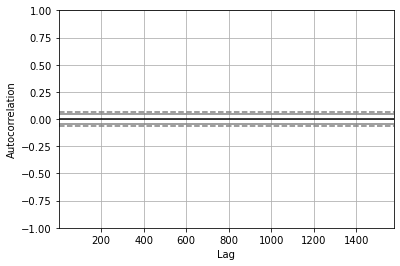

In [18]:
pd.plotting.autocorrelation_plot(x.resid);

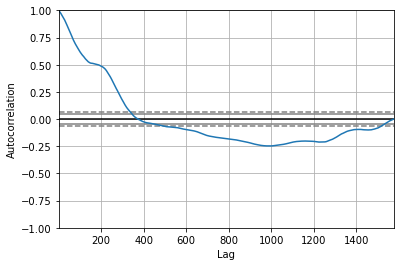

In [19]:
pd.plotting.autocorrelation_plot(daily['Close']);

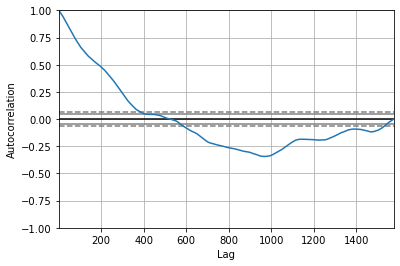

In [20]:
pd.plotting.autocorrelation_plot(daily['log_close']);

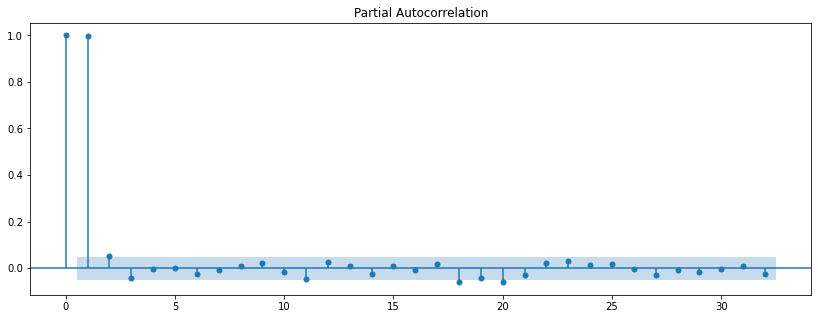

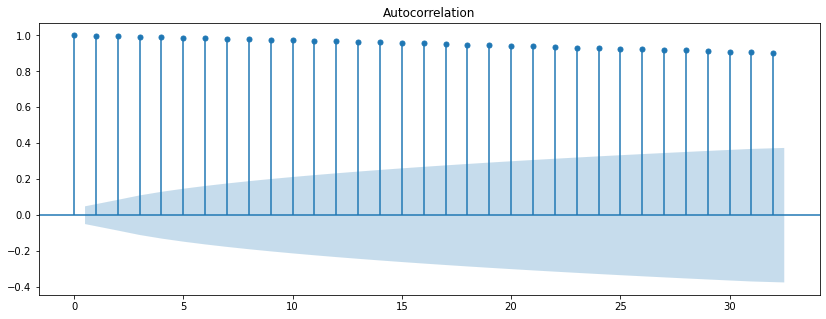

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(daily['log_close']);
plot_acf(daily['log_close']);

In [22]:
mod_arma = ARMA(x.resid.dropna(), order=(1,0))

In [23]:
res_arma = mod_arma.fit()

In [24]:
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                 1575
Model:                     ARMA(1, 0)   Log Likelihood                7617.498
Method:                       css-mle   S.D. of innovations              0.002
Date:                Tue, 04 Jan 2022   AIC                         -15228.995
Time:                        08:09:50   BIC                         -15212.909
Sample:                             0   HQIC                        -15223.017
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0000    3.1e-05   3.23e+04      0.000       1.000       1.000
ar.L1.resid    -0.5628      0.021    -27.021      0.000      -0.604      -0.522
                                    Roots       

In [25]:
mod2_arma = ARMA(x.resid.dropna(), order=(0,1))
res2_arma = mod2_arma.fit()
print(res2_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                 1575
Model:                     ARMA(0, 1)   Log Likelihood                7912.062
Method:                       css-mle   S.D. of innovations              0.002
Date:                Tue, 04 Jan 2022   AIC                         -15818.124
Time:                        08:09:50   BIC                         -15802.038
Sample:                             0   HQIC                        -15812.146
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0000   3.23e-07    3.1e+06      0.000       1.000       1.000
ma.L1.resid    -0.9931      0.005   -182.834      0.000      -1.004      -0.982
                                    Roots       

In [25]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

# Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(x.resid, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(x.resid, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             resid   No. Observations:                 1577
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 5)   Log Likelihood                7837.750
Date:                           Mon, 03 Jan 2022   AIC                         -15663.500
Time:                                   23:21:02   BIC                         -15631.344
Sample:                                        0   HQIC                        -15651.549
                                          - 1577                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9757      0.005   -395.048      0.000      -1.986      -1.966
ma.L2          0.9764      0.005    195.07

In [45]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

best_model = sm.tsa.statespace.SARIMAX(x.resid, order=(0, 1, 2),
                                       seasonal_order=(1, 1, 2, 5)).fit(disp=-1)

print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             resid   No. Observations:                 1577
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 5)   Log Likelihood                7837.750
Date:                           Tue, 04 Jan 2022   AIC                         -15663.500
Time:                                   09:18:04   BIC                         -15631.344
Sample:                                        0   HQIC                        -15651.549
                                          - 1577                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9757      0.005   -395.048      0.000      -1.986      -1.966
ma.L2          0.9764      0.005    195.078

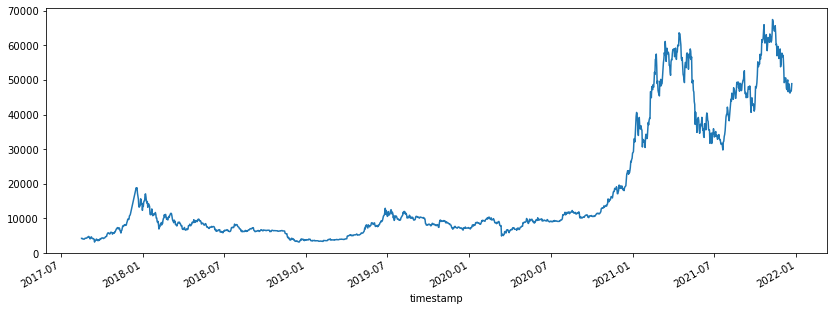

In [33]:
daily.Close.plot();

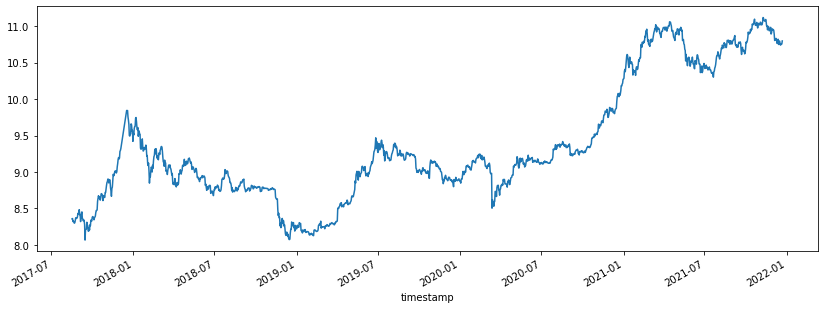

In [36]:
daily.log_close.plot();

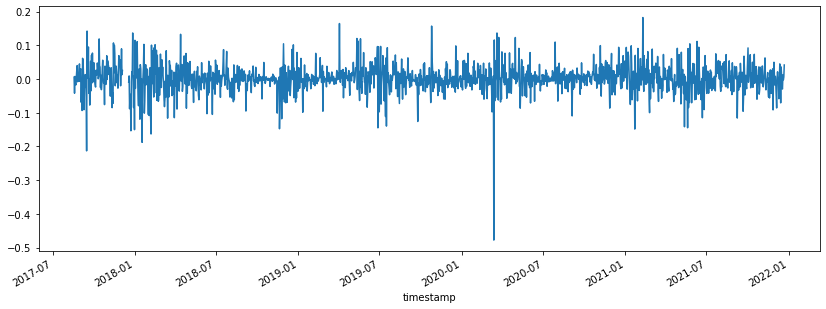

In [39]:
daily.log_diff.plot();

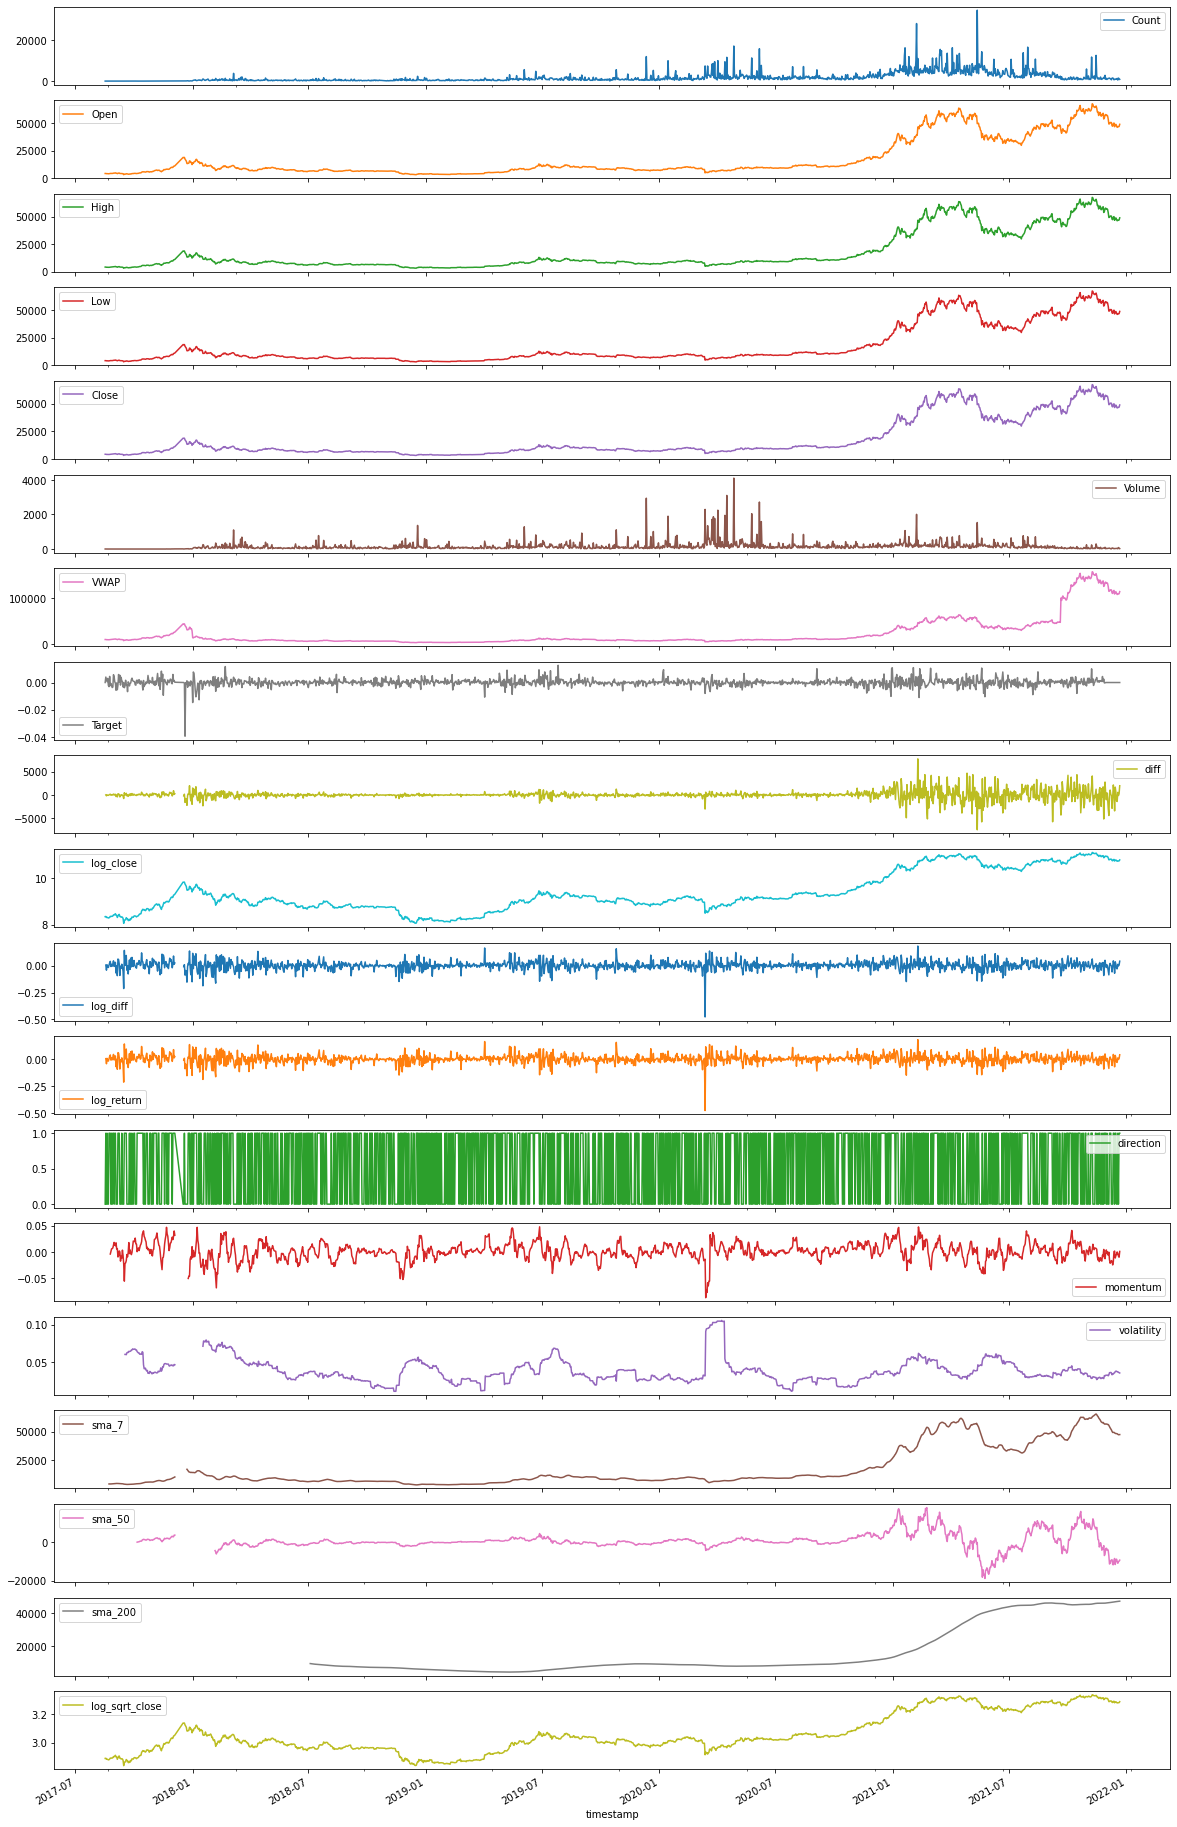

In [43]:
daily.plot(figsize=(20,36), subplots=True, legend=True);